In [1]:
import os
import re
import time
import string
import warnings
from typing import List

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, download as nltk_download
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False
    warnings.warn("wordcloud not installed; skipping word cloud")

BASE_URL = "https://www.airlinequality.com/airline-reviews/british-airways"
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

In [17]:
def ensure_nltk():
    resources = [
        ("tokenizers/punkt", "punkt"),
        ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
        ("corpora/wordnet", "wordnet"),
        ("corpora/omw-1.4", "omw-1.4"),
        ("corpora/stopwords", "stopwords"),
        ("sentiment/vader_lexicon", "vader_lexicon"),
    ]
    for path, pkg in resources:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk_download(pkg)

ensure_nltk()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
def fetch_reviews(pages: int = 5, page_size: int = 100, sleep: float = 1.25, timeout: int = 20) -> List[str]:
    """Fetch review snippets from paginated list pages."""
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; BAReviewsNotebook/1.0)",
        "Accept-Language": "en-US,en;q=0.9",
    }
    reviews = []
    for i in range(1, pages + 1):
        url = f"{BASE_URL}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        print(f"[fetch] page {i}: {url}")
        try:
            resp = requests.get(url, headers=headers, timeout=timeout)
            resp.raise_for_status()
        except Exception as e:
            print(f"  ! request failed ({e}); continuing")
            time.sleep(sleep)
            continue

        soup = BeautifulSoup(resp.content, "html.parser")
        blocks = soup.find_all("div", {"class": "text_content"})
        for b in blocks:
            txt = b.get_text(separator=" ", strip=True)
            if txt:
                reviews.append(txt)
        print(f"  -> collected {len(blocks)} | total {len(reviews)}")
        time.sleep(sleep)
    return reviews

In [5]:
raw_reviews = fetch_reviews(pages=10, page_size=100, sleep=1.5)
df = pd.DataFrame({"raw": raw_reviews})
df.to_csv(os.path.join(OUT_DIR, "ba_reviews_raw.csv"), index=False)
df.head()

[fetch] page 1: https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 100
[fetch] page 2: https://www.airlinequality.com/airline-reviews/british-airways/page/2/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 200
[fetch] page 3: https://www.airlinequality.com/airline-reviews/british-airways/page/3/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 300
[fetch] page 4: https://www.airlinequality.com/airline-reviews/british-airways/page/4/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 400
[fetch] page 5: https://www.airlinequality.com/airline-reviews/british-airways/page/5/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 500
[fetch] page 6: https://www.airlinequality.com/airline-reviews/british-airways/page/6/?sortby=post_date%3ADesc&pagesize=100
  -> collected 100 | total 600
[fetch] page 7: https://www.airlinequality.com/airline-reviews/british

,raw
0,✅ Trip Verified | Unable to check in and boo...
1,✅ Trip Verified | Was scheduled to fly to Gh...
2,Not Verified | British Airways economy cabin A...
3,Not Verified | I recently booked Club World ti...
4,✅ Trip Verified | A 45 minute queue to enter...


In [7]:
_PUNCT_TABLE = str.maketrans("", "", string.punctuation)
_LEMMA = WordNetLemmatizer()
_POS_MAP = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}

def strip_site_prefixes(text: str) -> str:
    """Remove 'Trip Verified |' style prefixes if present."""
    parts = [p.strip() for p in text.split("|")]
    return parts[-1] if len(parts) >= 2 else text

def normalize_text(text: str) -> str:
    lower = text.lower()
    no_punct = lower.translate(_PUNCT_TABLE)
    return re.sub(r"\s+", " ", no_punct).strip()

def tokenize_pos_stop(text: str):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    stop = set(stopwords.words("english"))
    return [(w, _POS_MAP.get(t[0])) for (w, t) in tags if w not in stop]

def lemmatize_pos(pairs) -> str:
    out = []
    for w, p in pairs:
        out.append(_LEMMA.lemmatize(w, pos=p) if p else w)
    return " ".join(out)

In [23]:
df["review"] = df["raw"].map(strip_site_prefixes)
df["normalized"] = df["review"].map(normalize_text)
df["pos_pairs"] = df["normalized"].map(tokenize_pos_stop)
df["lemma"] = df["pos_pairs"].map(lemmatize_pos)
df[["raw", "review", "lemma"]].head(10)

,raw,review,lemma
0,✅ Trip Verified | Unable to check in and boo...,Unable to check in and book seats due to BA we...,unable check book seat due ba website crashing...
1,✅ Trip Verified | Was scheduled to fly to Gh...,Was scheduled to fly to Ghana on the 31st July...,schedule fly ghana 31st july 2025 gatwick airp...
2,Not Verified | British Airways economy cabin A...,British Airways economy cabin A320 is some kin...,british airway economy cabin a320 kind joke co...
3,Not Verified | I recently booked Club World ti...,I recently booked Club World tickets (business...,recently book club world ticket business class...
4,✅ Trip Verified | A 45 minute queue to enter...,A 45 minute queue to enter the lounge (needed ...,45 minute queue enter lounge need work possibl...
5,✅ Trip Verified | The airline delayed my flig...,The airline delayed my flight from Dublin caus...,airline delay flight dublin cause miss connect...
6,✅ Trip Verified | I booked a flight for my tra...,"I booked a flight for my travel on Oct 10, 202...",book flight travel oct 10 2025 go bacom book p...
7,✅ Trip Verified | Flying on BA104 on 11/09/25...,Flying on BA104 on 11/09/25 I was disappointed...,fly ba104 110925 disappoint level service prov...
8,✅ Trip Verified | Flight delayed 1 hr and 8 ...,Flight delayed 1 hr and 8 min. Flight crew fri...,flight delay 1 hr 8 min flight crew friendly e...
9,✅ Trip Verified | My wife and I flew from Vanc...,My wife and I flew from Vancouver (YVR) to Lon...,wife fly vancouver yvr london lhr business cla...


In [22]:
def ensure_nltk():
    try:
        nltk_download('averaged_perceptron_tagger')
    except LookupError:
        pass

    try:
        nltk_download('averaged_perceptron_tagger_eng')
    except LookupError:
        pass

    resources = [
        ("tokenizers/punkt", "punkt"),
        ("corpora/wordnet", "wordnet"),
        ("corpora/omw-1.4", "omw-1.4"),
        ("corpora/stopwords", "stopwords"),
        ("sentiment/vader_lexicon", "vader_lexicon"),
    ]
    for path, pkg in resources:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk_download(pkg)

ensure_nltk()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
analyzer = SentimentIntensityAnalyzer()

def classify_compound(text: str) -> float:
    return analyzer.polarity_scores(text)["compound"]

def label_from_compound(score: float) -> str:
    if score >= 0.5:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

df["compound"] = df["lemma"].map(classify_compound)
df["sentiment"] = df["compound"].map(label_from_compound)

df[["review", "lemma", "compound", "sentiment"]].head(10)

,review,lemma,compound,sentiment
0,Unable to check in and book seats due to BA we...,unable check book seat due ba website crashing...,-0.9217,Negative
1,Was scheduled to fly to Ghana on the 31st July...,schedule fly ghana 31st july 2025 gatwick airp...,-0.9468,Negative
2,British Airways economy cabin A320 is some kin...,british airway economy cabin a320 kind joke co...,0.7261,Positive
3,I recently booked Club World tickets (business...,recently book club world ticket business class...,-0.4271,Negative
4,A 45 minute queue to enter the lounge (needed ...,45 minute queue enter lounge need work possibl...,-0.8910,Negative
5,The airline delayed my flight from Dublin caus...,airline delay flight dublin cause miss connect...,-0.9231,Negative
6,"I booked a flight for my travel on Oct 10, 202...",book flight travel oct 10 2025 go bacom book p...,0.0516,Neutral
7,Flying on BA104 on 11/09/25 I was disappointed...,fly ba104 110925 disappoint level service prov...,0.5106,Positive
8,Flight delayed 1 hr and 8 min. Flight crew fri...,flight delay 1 hr 8 min flight crew friendly e...,0.8807,Positive
9,My wife and I flew from Vancouver (YVR) to Lon...,wife fly vancouver yvr london lhr business cla...,0.2500,Neutral


In [25]:
counts = df["sentiment"].value_counts().reindex(["Positive", "Neutral", "Negative"]).fillna(0).astype(int)
counts

,count
sentiment,
Positive,446
Neutral,108
Negative,446


In [26]:
out_path = os.path.join(OUT_DIR, "ba_reviews_analysed.csv")
df.drop(columns=["pos_pairs"]).to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data/ba_reviews_analysed.csv


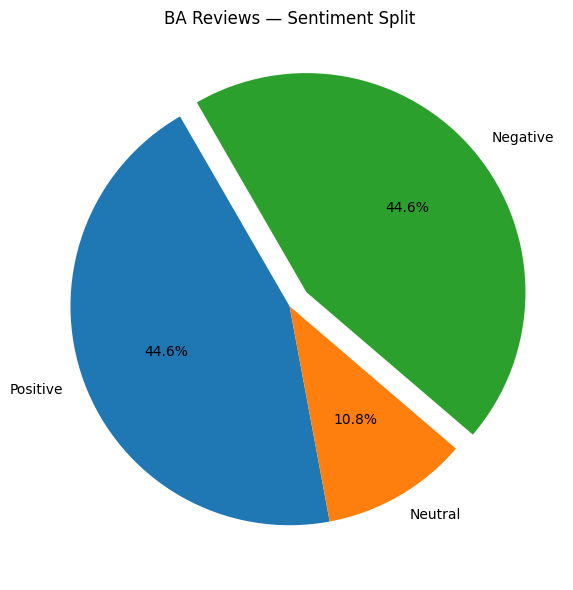

In [27]:
plt.figure(figsize=(6,6))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct="%.1f%%",
    startangle=120,
    explode=[0,0,0.1]
)
plt.title("BA Reviews — Sentiment Split")
plt.tight_layout()
plt.show()

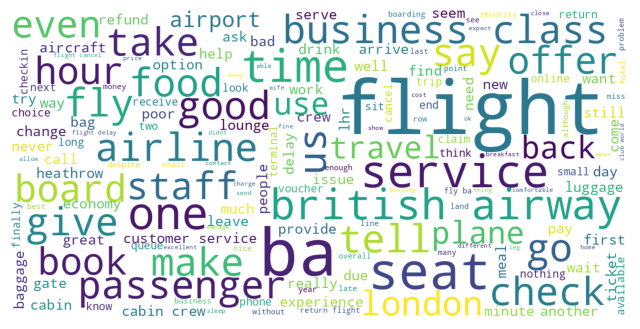

In [28]:
if WORDCLOUD_AVAILABLE:
    wc = WordCloud(background_color="white", max_words=400, max_font_size=48, scale=3, random_state=7)
    img = wc.generate(" ".join(df["lemma"].astype(str)))
    plt.figure(figsize=(8,8)); plt.axis("off"); plt.imshow(img); plt.show()
else:
    print("Install `wordcloud` to enable this plot.")